In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir(module_path)

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from torchinfo import summary

In [3]:
import seaborn as sns
import matplotlib as mpl

mpl.rc('figure', figsize=(10, 4), dpi=100)
sns.set_theme()

In [4]:
from models.score_base import TabScoreModel
from configs import adult_config, adult_opt_config

config = adult_opt_config.get_config()
config.model.estimate_noise = True
config.model.layers=6
config.model.ndims=512
config.model.embedding_type="positional"
config.model.act="swish"
workdir = "workdir/adult/long-kl/"

ckpt_dir = os.path.join(workdir,"checkpoints", "last.ckpt")
# ckpt_dir = os.path.join(workdir,"checkpoints-meta", "last.ckpt")
scorenet = TabScoreModel.load_from_checkpoint(
    checkpoint_path=ckpt_dir, config=config).cuda()

scorenet.eval()

Restored checkpoint from EMA...


TabScoreModel(
  (net): TabResNet(
    (time_embed): Sequential(
      (0): PositionalEncoding()
      (1): Linear(in_features=128, out_features=128, bias=True)
      (2): SiLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): SiLU()
    )
    (proj): Linear(in_features=108, out_features=512, bias=True)
    (resnet): ModuleList(
      (0): TabResBlockpp(
        (norm): GroupNorm(8, 512, eps=1e-05, affine=True)
        (dense_1): Linear(in_features=512, out_features=512, bias=True)
        (film): FiLMBlock(
          (dense): Linear(in_features=128, out_features=1024, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (dense_2): Linear(in_features=512, out_features=512, bias=True)
      )
      (1): TabResBlockpp(
        (norm): GroupNorm(8, 512, eps=1e-05, affine=True)
        (dense_1): Linear(in_features=512, out_features=512, bias=True)
        (film): FiLMBlock(
          (dense): Linear(in_features=128, out_features=1024, bi

In [5]:
# ckpt_dir = os.path.join("workdir/mlp/test-ema","checkpoints-meta", "last-v1.ckpt")
# checkpoint = torch.load(ckpt_dir)
# checkpoint.keys()

# checkpoint["callbacks"]["EMA"].keys()

In [5]:
from dataloader import get_dataset, build_tabular_ds
from torch.utils.data import DataLoader
from models.mutils import onehot_to_logit

In [6]:
X_ds = build_tabular_ds(config.data.dataset)

test_loader = DataLoader(
    X_ds,
    batch_size=2048,
    pin_memory=False,
    num_workers=0,
)
test_loader

In [7]:
from torch.utils.data import Subset
ano_idxs = [idx for idx, (x,y) in enumerate(X_ds) if y.argmax() == 1]
ood_data = Subset(X_ds, ano_idxs)
ood_data = DataLoader(ood_data, batch_size=2048, pin_memory=False, num_workers=0)

In [81]:
%%time

score_norms = []
labels = []
with torch.cuda.device(0):
    for x_batch, y in test_loader:
        # x_cont = x_batch[:, : scorenet.continuous_dims]
        # x_cat = x_batch[:, scorenet.continuous_dims :]
        # x_cat = onehot_to_logit(x_cat)
        # tau = scorenet.taus[timestep_idxs][:, None]
        # x_cat = torch.cat(
        #     [
        #         log_concrete_sample(x_cat_hot, tau=tau)
        #         for x_cat_hot in scorenet.splitter(x_cat)
        #     ],
        #     dim=1,
        # )
        # x = torch.cat((x_cont, x_cat), dim=1).cuda()    
        s = scorenet.scorer(x_batch.cuda(), denoise_step=False).cpu().numpy()
        score_norms.append(s)
        
        labels.append(y.argmax(dim=1).numpy())
        
len(score_norms)

CPU times: user 667 ms, sys: 20.7 ms, total: 687 ms
Wall time: 686 ms


16

In [82]:
score_norms[0]

array([[ 91.71779 ,  62.813744,  46.350918, ...,  12.994234,  11.449693,
          9.001686],
       [ 87.62269 ,  61.077484,  45.35067 , ...,  11.154879,  10.050854,
          9.172415],
       [102.56803 ,  70.71398 ,  50.86135 , ...,  13.402087,  10.588346,
          9.726723],
       ...,
       [ 76.3862  ,  45.736134,  29.81136 , ...,  19.065706,  18.394024,
         17.987112],
       [ 85.73712 ,  57.13876 ,  36.929256, ...,  29.903599,  27.390902,
         25.875341],
       [ 77.5586  ,  49.618717,  30.605974, ...,  24.30764 ,  20.418177,
         20.260675]], dtype=float32)

In [83]:
%%time

alpha = 0.8
ood_score_norms = []
ano_labels = []
with torch.cuda.device(0):
    for x_batch, y in ood_data:
        x_cont = x_batch[:, : scorenet.continuous_dims]
        x_cat = x_batch[:, scorenet.continuous_dims :]
        
        x_cont_ood = alpha * x_cont + (1-alpha) * x_cont[torch.randperm(x_cont.shape[0])]
        x_cat_ood = x_cat[torch.randperm(x_cat.shape[0])]
        x_ood = torch.cat((x_cont_ood, x_cat_ood), dim=1).cuda()
        s = scorenet.scorer(x_ood, denoise_step=False).cpu().numpy()
        ood_score_norms.append(s)
        
        ano_labels.append(y.argmax(dim=1).numpy()+1)

CPU times: user 3.2 s, sys: 264 ms, total: 3.46 s
Wall time: 183 ms


In [84]:
# for idx in range(1):
#     scorenet.eval()
#     with torch.no_grad():
#         vec_t = torch.ones((x_batch.shape[0],), device=x.device, dtype=torch.long) * idx
#         # score = scorenet.score_fn(x, vec_t)
#         tau = scorenet.taus[vec_t.long()][:, None]
#         logit_noise_est = scorenet.net(x, vec_t.float())
#         cat_logits = logit_noise_est[:, scorenet.continuous_dims :]
#         cont_score = logit_noise_est[:, : scorenet.continuous_dims]
        
#         for l in scorenet.splitter(cat_logits):
#             s = l.shape[1] * F.softmax(l, dim=1)
#             sns.heatmap(s.cpu())
#             plt.show()

#     # print(score.shape)

In [85]:
x_ood.shape

torch.Size([1697, 108])

In [86]:
scores = np.vstack(score_norms)
labels = np.concatenate(labels, axis=0)
scores.shape

(32561, 10)

In [87]:
ood_scores = np.vstack(ood_score_norms)
ano_labels = np.concatenate(ano_labels, axis=0)

In [88]:
df2 = pd.DataFrame(ood_scores, columns=[f"t{i}" for i in range(config.model.num_scales)])
df2["labels"] = ano_labels
df2

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,labels
0,83.234505,58.543102,42.369732,33.584064,32.674873,33.898220,40.791233,45.180851,41.861225,41.257652,2
1,73.018135,57.903328,52.769161,47.669430,42.493843,42.567551,47.394245,47.593025,41.191776,37.251560,2
2,85.847130,59.676388,46.644207,43.235687,42.971611,36.719124,33.050541,36.179832,44.390530,53.178818,2
3,66.724312,44.970119,33.290882,25.266266,21.307056,18.133797,19.085472,23.841324,32.998837,46.385506,2
4,68.051193,47.087696,33.716396,27.393171,24.532192,26.002560,33.744366,38.917961,41.624260,41.240856,2
...,...,...,...,...,...,...,...,...,...,...,...
7836,72.619545,47.956284,30.284552,20.716600,18.970854,25.115311,45.323902,41.716579,32.571362,23.405325,2
7837,79.982979,55.786240,34.128365,23.345768,20.012646,22.289976,26.688314,48.304237,41.073757,36.337330,2
7838,65.641350,44.083889,28.572910,19.022797,13.569938,11.750239,13.557484,19.841352,30.111673,43.315624,2
7839,69.932167,47.006802,31.587700,23.192957,20.983265,35.783703,52.836769,46.015316,37.279999,30.526224,2


In [89]:
df = pd.DataFrame(scores, columns=[f"t{i}" for i in range(config.model.num_scales)])
df["labels"] = labels
df2 = pd.DataFrame(ood_scores, columns=[f"t{i}" for i in range(config.model.num_scales)])
df2["labels"] = ano_labels
df = pd.concat([df, df2], axis=0)
df_melt = df.melt(id_vars="labels", var_name="tau")
df_melt.head()

,labels,tau,value
0,0,t0,91.717789
1,0,t0,87.622688
2,0,t0,102.568031
3,0,t0,83.735657
4,0,t0,90.554695


In [90]:
df.labels.value_counts()

0    24720
1     7841
2     7841
Name: labels, dtype: int64

<AxesSubplot:xlabel='tau', ylabel='value'>

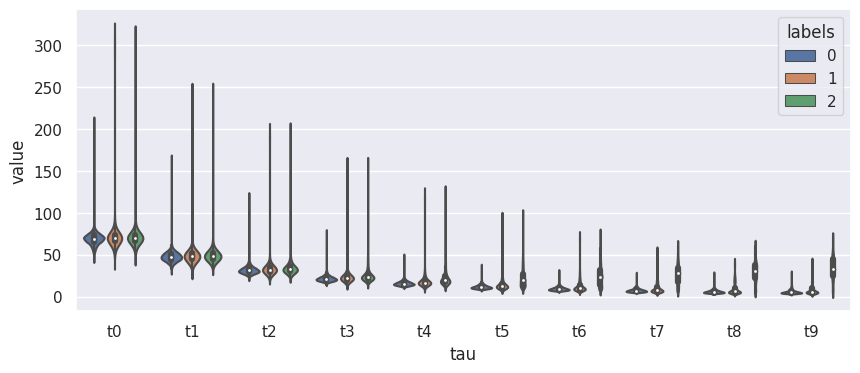

In [91]:
sns.violinplot(data=df_melt, y="value", x="tau", split=False, hue="labels")

<AxesSubplot:xlabel='tau', ylabel='value'>

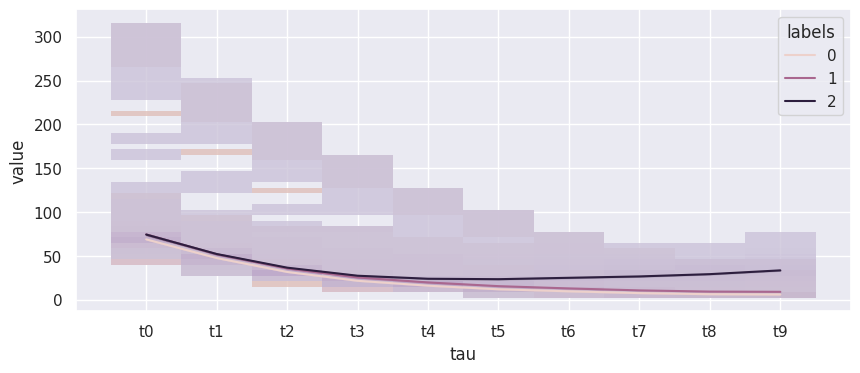

In [92]:
ax=sns.histplot(data=df_melt, y="value", x="tau", hue="labels", alpha=0.8, bins=50)
sns.lineplot(data=df_melt, y="value", x="tau", ci=99, hue="labels", ax=ax)

### With climbing FIXME: just put one-hot into the dataloader itself 

In [68]:
climbed_score_norms = []
climbed_labels = []

with torch.cuda.device(0):
    for x_batch, y in test_loader:
        s = scorenet.scorer(x_batch.cuda(), denoise_step=True).cpu().numpy()
        climbed_score_norms.append(s)
        climbed_labels.append(y.argmax(dim=1).numpy())
        break

In [69]:
climbed_scores = np.vstack(climbed_score_norms)
climbed_labels = np.concatenate(label_list, axis=0)

In [70]:
climbed_scores

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [64]:
df = pd.DataFrame(climbed_scores, columns=[f"s{i}" for i in range(climbed_scores.shape[1])])
df["labels"] = climbed_labels
df_melt = df.melt(id_vars="labels", var_name="tau")
# df.head()

<AxesSubplot:xlabel='tau', ylabel='value'>

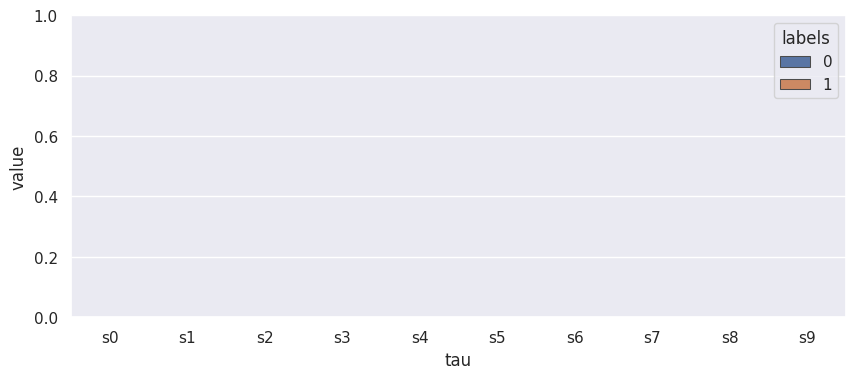

In [65]:
sns.violinplot(data=df_melt, y="value", x="tau", split=True, hue="labels")

<AxesSubplot:xlabel='tau', ylabel='value'>

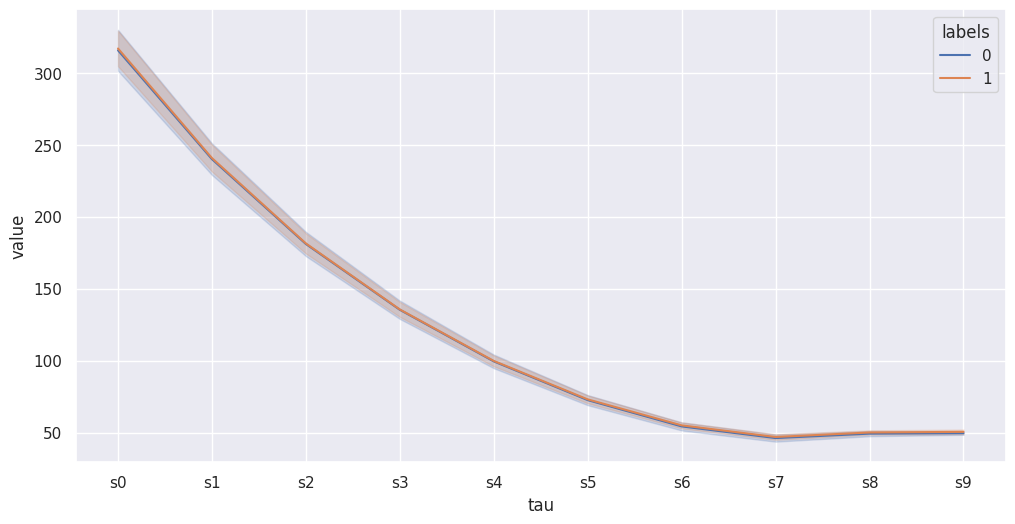

In [ ]:
sns.lineplot(data=df, y="value", x="tau", ci="sd", hue="labels")

### Analysis

========================= Training GMM =========================
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best: -8.786748 using {'GMM__covariance_type': 'full', 'GMM__n_components': 5}
---------------------------------------------------------------------------
-8.786748 (1.817635) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 5}


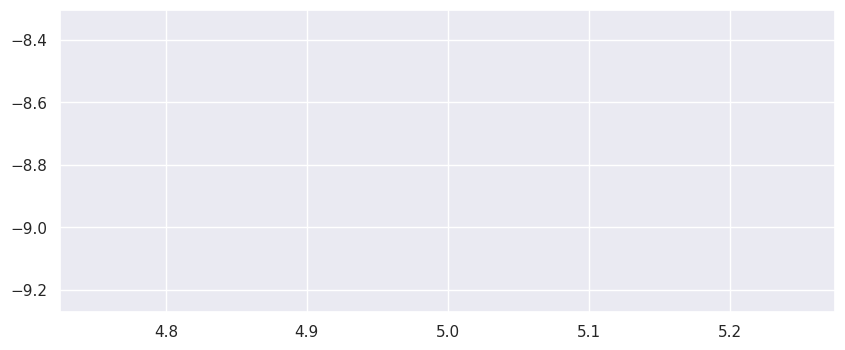

---Likelihoods---
Training: -3.153
Inlier: -3.138
Outlier: -4.888
OOD: -67.879
========================= Training KD Tree =========================
CPU times: user 34.8 s, sys: 54.1 s, total: 1min 28s
Wall time: 4.48 s


In [93]:
%%time
from ood_detection_helper import ood_metrics, auxiliary_model_analysis

X_train = scores[labels==0]
X_ano = scores[labels==1]
X_ood = ood_scores
results = auxiliary_model_analysis(X_train[::2], X_train[1::2], [X_ano, X_ood],
                                   components_range=range(5,6),
                                   labels=["Train", "Inlier", "Outlier", "OOD"])

In [94]:
X_train[::2].shape, X_ood.shape

((12360, 10), (7841, 10))

In [95]:
results["GMM"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
Outlier,93.697411,39.774168,61.961093,59.135631,67.450489,71.982201,59.138270
OOD,19.368932,7.087525,96.830704,96.840369,96.696166,0.161812,96.840514


Inlier vs Outlier
----------------
ROC-AUC: 61.9611
PR-AUC (In/Out): 59.1356 / 67.4505
FPR (95% TPR): 93.70%
Detection Error: 39.77%


,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
Outlier,93.697411,39.774168,61.961093,59.135631,67.450489,71.982201,59.138270
OOD,19.368932,7.087525,96.830704,96.840369,96.696166,0.161812,96.840514


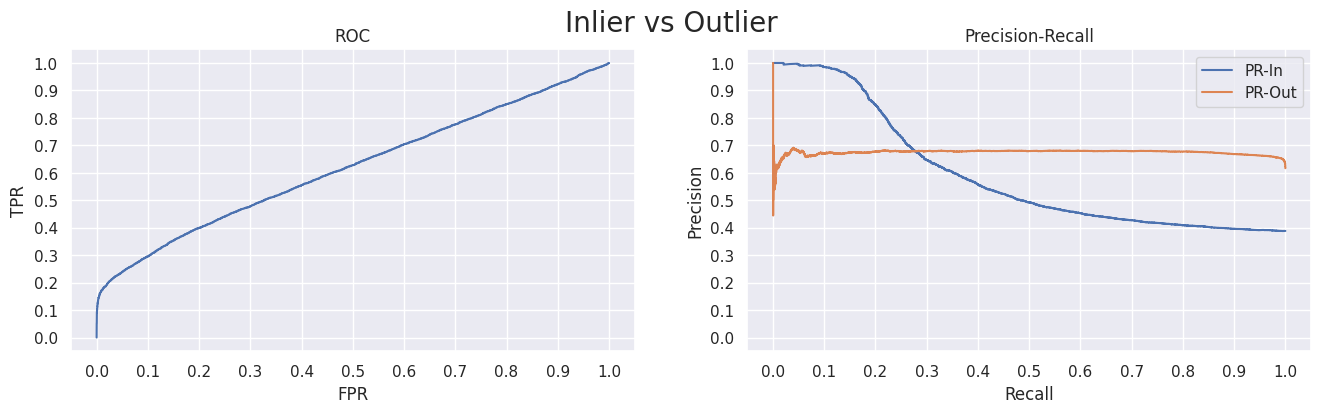

In [96]:
ood_metrics(-results["GMM"]["test_scores"], -results["GMM"]["ood_scores"][0], plot=True, verbose=True)
results["GMM"]["metrics"]

Inlier vs Outlier
----------------
ROC-AUC: 96.8307
PR-AUC (In/Out): 96.8404 / 96.6962
FPR (95% TPR): 19.37%
Detection Error: 7.09%


{'fpr_tpr95': 0.19368932038834952,
 'de': 0.07087525161286064,
 'roc_auc': 0.9683070359974064,
 'pr_auc_in': 0.9684036946337087,
 'pr_auc_out': 0.9669616583012872,
 'fpr_tpr80': 0.0016181229773462784,
 'ap': 0.9684051412572954}

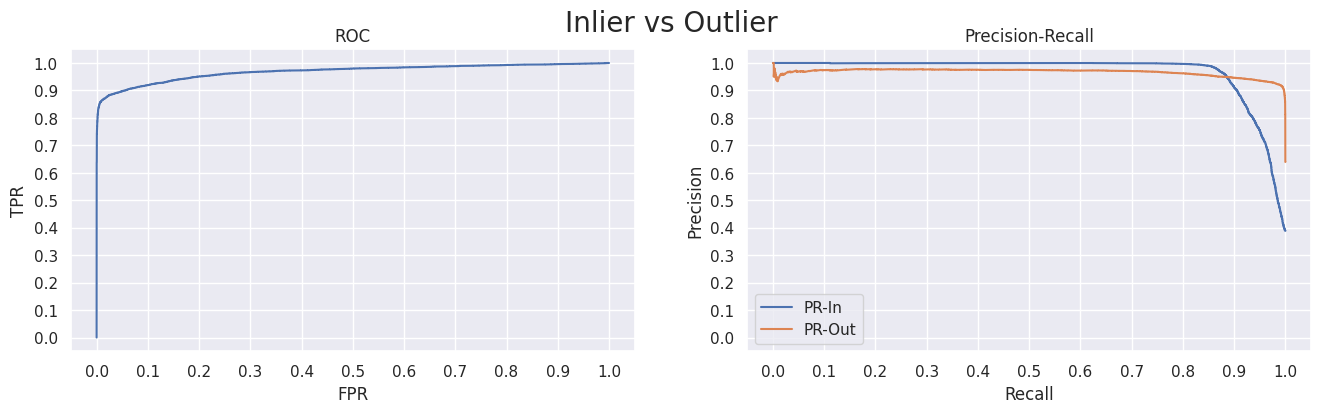

In [97]:
ood_metrics(-results["GMM"]["test_scores"], -results["GMM"]["ood_scores"][1], plot=True, verbose=True)
